In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

2025-01-16 13:58:09.845583: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 13:58:09.853475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737010689.861720    2262 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737010689.864186    2262 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 13:58:09.873602: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Set up GPU device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


## 01 Loading Dataset

In [3]:
def load_h5_data(filename, dataset_name="dataset"):
    """
    Load data from an HDF5 file.

    Parameters:
    - filename (str): The name of the HDF5 file to load.
    - dataset_name (str): The name of the dataset to load. Default is 'dataset'.

    Returns:
    - numpy.ndarray: The data loaded from the HDF5 file.
    """
    try:
        with h5py.File(filename, "r") as h5f:
            # Check if the dataset exists
            if dataset_name not in h5f:
                raise KeyError(f"Dataset '{dataset_name}' not found in the file.")
            
            # Load the dataset
            data = h5f[dataset_name][:]
            
        print(f"Data successfully loaded from '{filename}', dataset '{dataset_name}'.")
        print(f"Data shape: {data.shape}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None
def mean_spectrum(data, sampling_rate):
    """
    Plots the normalized mean spectrum of frequency for a 2D seismic shot gather.
    
    Parameters:
    - data: 2D numpy array (time samples x traces), seismic shot gather data.
    - sampling_rate: Sampling rate in Hz (number of samples per second).
    """
    # Number of time samples and traces
    n_samples, n_traces = data.shape
    
    # Fourier transform along the time axis (axis=0)
    fft_data = np.fft.fft(data, axis=0)
    
    # Calculate the frequency axis
    freq = np.fft.fftfreq(n_samples, d=1/sampling_rate)
    
    # Only keep the positive frequencies
    positive_freq = freq[:n_samples // 2]
    positive_fft = fft_data[:n_samples // 2, :]
    
    # Compute the amplitude spectrum
    amplitude_spectrum = np.abs(positive_fft)
    
    # Mean spectrum across all traces
    mean_spectrum = np.mean(amplitude_spectrum, axis=1)
    
    # Normalize the mean spectrum
    # normalized_mean_spectrum = mean_spectrum / np.max(mean_spectrum)

    return positive_freq, mean_spectrum

In [4]:
# path_raw_data = "../data/datasets/outputs/raw_patches_norm.h5"
# raw_data = load_h5_data(path_raw_data, dataset_name="dataset")
raw_data = np.load('../data/datasets/outputs/raw_from_paper.npy')

QC dataset by ploting sample patches

In [6]:
import tensorflow as tf
import numpy as np
from scipy import signal

def highpass_filter(data, freq, dt, pad=None):
    """
    Perform high-pass filter on data using SciPy.
    Args:
        freq (float): The cut-off frequency (in Hz).
        data (np.ndarray): Data to be filtered, shape (..., nt, :), where nt = number of time samples.
        dt (float): Time sampling rate of the data (in seconds).
        pad (int, optional): Padding size (before and after, with zeros) before filter.
                             Defaults to None (no padding).
    Returns:
        np.ndarray: High-pass filtered data.
    """
    # Apply padding if specified
    if pad is not None:
        pad_width = [(0, 0)] * (data.ndim - 2) + [(pad, pad), (0, 0)]
        data = np.pad(data, pad_width, mode='reflect')

    # Design the high-pass Butterworth filter
    nyquist = 0.5 / dt  # Nyquist frequency
    sos = signal.butter(8, freq / nyquist, btype='highpass', output='sos')

    # Apply the filter
    filtered_data = signal.sosfiltfilt(sos, data, axis=-2)

    # Remove padding if applied
    if pad is not None:
        filtered_data = filtered_data[..., pad:-pad, :]

    return filtered_data

def preprocess_highpass_filter(data, freq, dt, pad=64):
    """
    TensorFlow wrapper for high-pass filtering using tf.py_function.
    Args:
        data (tf.Tensor): Input data tensor of shape (..., nt, :).
        freq (tuple): Tuple (min_freq, max_freq) defining the range of cutoff frequencies in Hz.
        dt (float): Time sampling interval in seconds.
        pad (int): Padding size for filtering.
    Returns:
        tf.Tensor: Filtered data tensor.
    """
    def filter_fn(data_np):
        # Generate a random frequency within the range
        freq_cut = np.random.uniform(freq[0], freq[1])
        return highpass_filter(data_np, freq_cut, dt, pad)

    # Use tf.py_function to call the filtering function
    filtered_data = tf.py_function(filter_fn, [data], tf.float32)
    # Preserve shape information (important for TensorFlow pipelines)
    filtered_data.set_shape(data.shape)

    return filtered_data
    
    
# Example Parameters
freq = (6, 30)  # High-pass cutoff frequency range in Hz
dt = 0.002  # Time sampling interval in seconds

# Create a Dataset
label_data = tf.data.Dataset.from_tensor_slices(raw_data)

# Apply High-Pass Filter Preprocessing
input_data = label_data.map(
    lambda x: preprocess_highpass_filter(x, freq, dt),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Combine Original and Processed Data into a New Dataset
combined_dataset = tf.data.Dataset.zip((input_data, label_data))

# Expand_Dim Batch and Prefetch for Optimization
combined_dataset = combined_dataset.map(lambda x, y: (tf.expand_dims(x, axis=-1), tf.expand_dims(y, axis=-1))).batch(64).prefetch(tf.data.AUTOTUNE)
train_size = int(0.9 * len(combined_dataset))
train_dataset = combined_dataset.take(train_size)
val_dataset = combined_dataset.skip(train_size)

I0000 00:00:1737010694.520069    2262 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9706 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


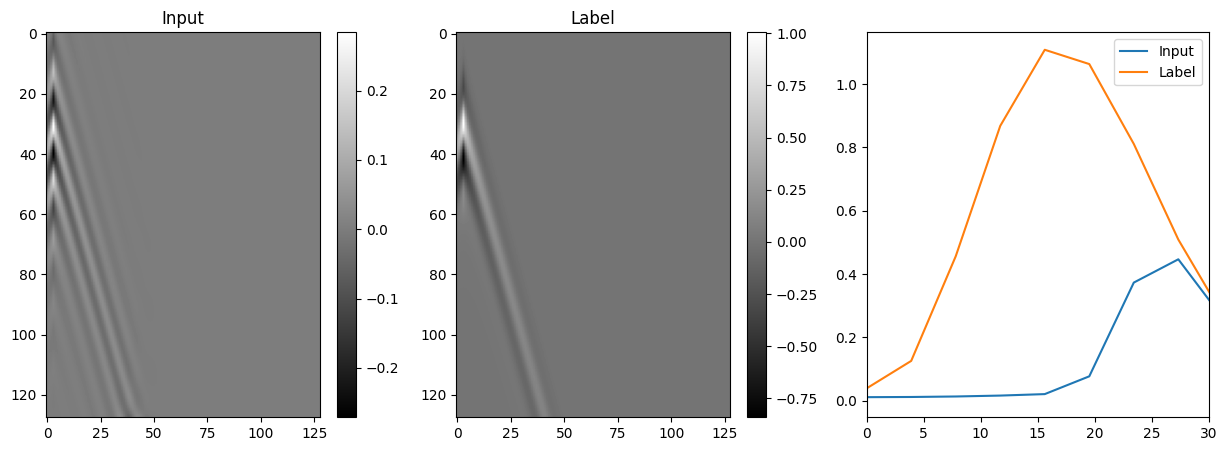

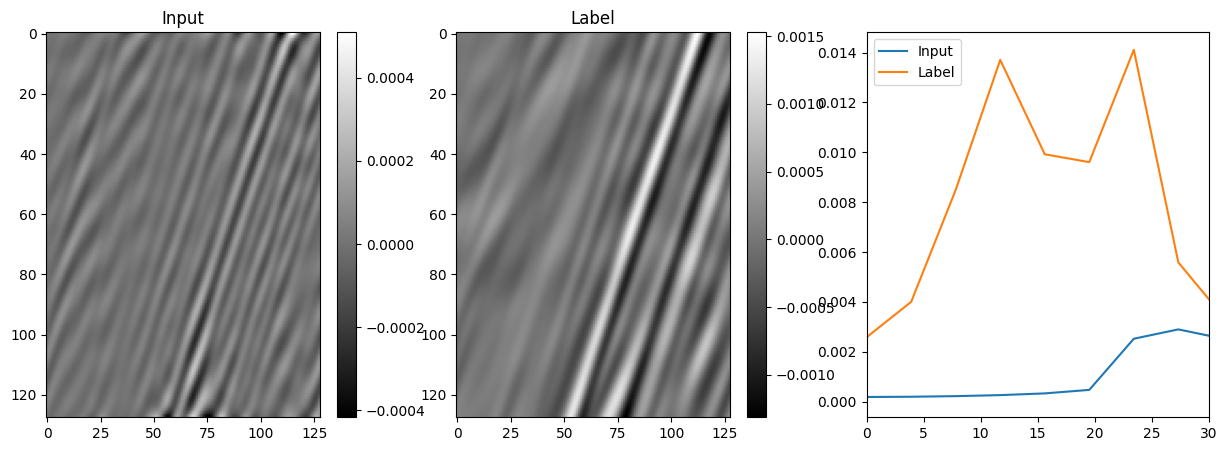

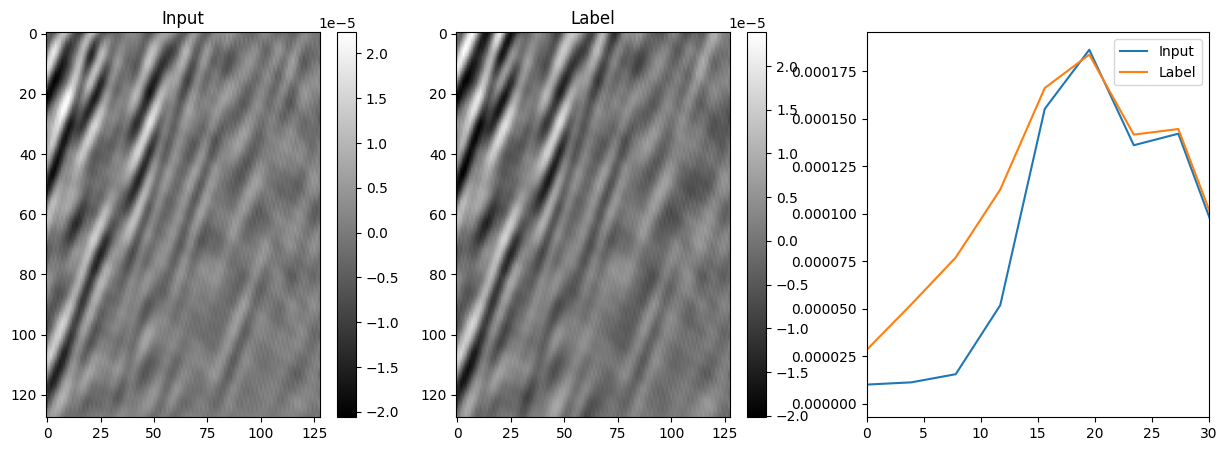

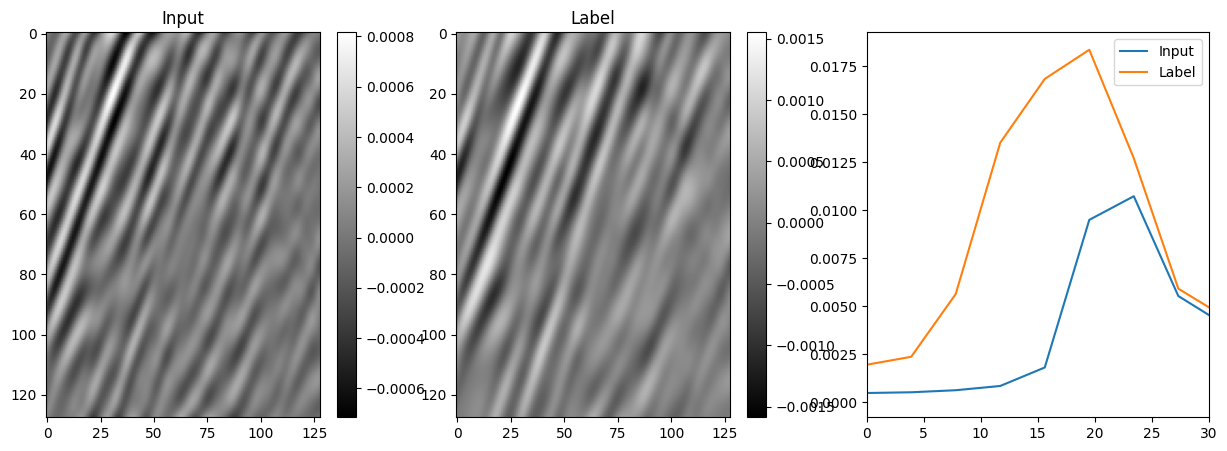

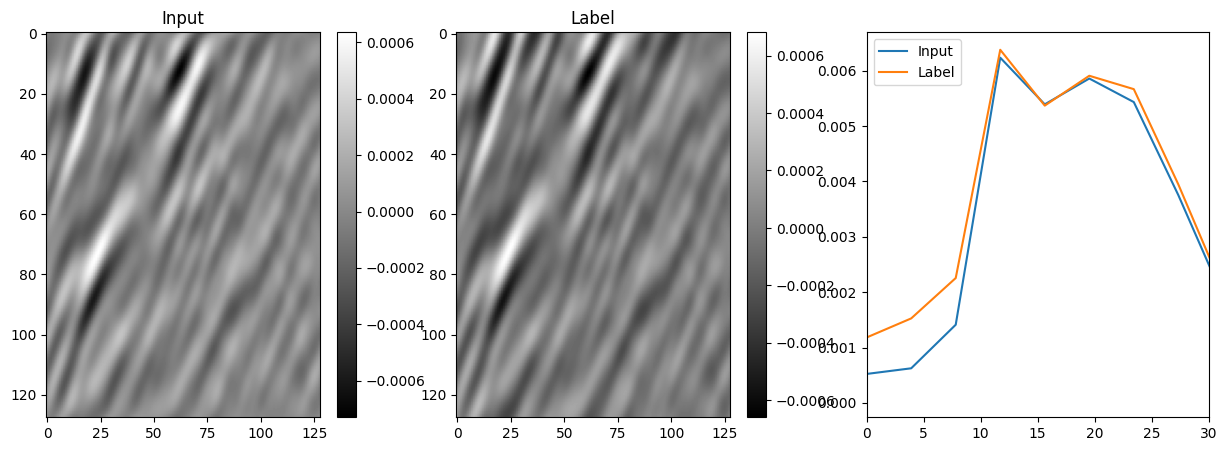

In [7]:
sample = train_dataset.take(1)
(x, y) = next(sample.as_numpy_iterator())

sampling_rate = 1 / (2e-3)
plt.close()
i = 0
for x_sample, y_sample in zip(x, y):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input")
    plt.imshow(x_sample, aspect="auto", cmap="gray")
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.title("Label")
    plt.imshow(y_sample, aspect="auto", cmap="gray")
    plt.colorbar()
    plt.subplot(1, 3, 3)
    freq, spect_input = mean_spectrum(np.squeeze(x_sample), sampling_rate)
    freq, spect_output = mean_spectrum(np.squeeze(y_sample), sampling_rate)
    plt.plot(freq, spect_input, label="Input")
    plt.plot(freq, spect_output, label="Label")
    
    plt.xlim(0, 30)
    plt.legend()
    
    i+=1
    if i==5:
        break

## 02 Networks Architecture

### Define Hybrid Loss Function

In [8]:
from tensorflow.keras.saving import register_keras_serializable

def amplitude_spectrum_loss(y_true, y_pred):
    # Reshape to ensure proper dimensions for FFT
    y_true = tf.squeeze(y_true, axis=-1)  # Remove the last dimension (128, 128)
    y_pred = tf.squeeze(y_pred, axis=-1)  # Remove the last dimension (128, 128)

    # Perform FFT along the second axis (columns)
    true_spectrum = tf.signal.fft(tf.cast(y_true, tf.complex64))
    pred_spectrum = tf.signal.fft(tf.cast(y_pred, tf.complex64))

    # Compute the amplitude spectrum (magnitude of the complex number)
    true_amplitude = tf.abs(true_spectrum)
    pred_amplitude = tf.abs(pred_spectrum)

    # Return the mean squared error of the amplitude spectrum
    return tf.reduce_mean(tf.square(true_amplitude - pred_amplitude))


@register_keras_serializable()
def hybrid_loss(y_true, y_pred):
    # MAE Loss
    mae_loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    
    # Amplitude Spectrum Loss
    spec_loss = amplitude_spectrum_loss(y_true, y_pred)
    
    # Combine the two losses (you can adjust the weighting factor here)
    total_loss = mae_loss + 0.01 * spec_loss
    return total_loss

In [9]:
def unet_model_v2(inputs_shape=(None, None, 1)):
    inputs = tf.keras.layers.Input(inputs_shape)

    # Encoder Blocks
    c1 = tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation=None)(inputs)
    c1 = tf.keras.layers.LeakyReLU(alpha=0.1)(c1)
    c1 = tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation=None)(c1)
    c1 = tf.keras.layers.LeakyReLU(alpha=0.1)(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation=None)(p1)
    c2 = tf.keras.layers.LeakyReLU(alpha=0.1)(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation=None)(p2)
    c3 = tf.keras.layers.LeakyReLU(alpha=0.1)(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation=None)(p3)
    c4 = tf.keras.layers.LeakyReLU(alpha=0.1)(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation=None)(p4)
    c5 = tf.keras.layers.LeakyReLU(alpha=0.1)(c5)
    p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

    # Bottleneck
    b = tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation=None)(p5)
    b = tf.keras.layers.LeakyReLU(alpha=0.1)(b)
    b = tf.keras.layers.UpSampling2D((2, 2))(b)

    # Decoder Blocks
    d4 = tf.keras.layers.Concatenate()([b, c5])
    d4 = tf.keras.layers.Conv2D(96, (3, 3), padding='same', activation=None)(d4)
    d4 = tf.keras.layers.LeakyReLU(alpha=0.1)(d4)
    d4 = tf.keras.layers.UpSampling2D((2, 2))(d4)

    d3 = tf.keras.layers.Concatenate()([d4, c4])
    d3 = tf.keras.layers.Conv2D(96, (3, 3), padding='same', activation=None)(d3)
    d3 = tf.keras.layers.LeakyReLU(alpha=0.1)(d3)
    d3 = tf.keras.layers.UpSampling2D((2, 2))(d3)

    d2 = tf.keras.layers.Concatenate()([d3, c3])
    d2 = tf.keras.layers.Conv2D(96, (3, 3), padding='same', activation=None)(d2)
    d2 = tf.keras.layers.LeakyReLU(alpha=0.1)(d2)
    d2 = tf.keras.layers.UpSampling2D((2, 2))(d2)

    d1 = tf.keras.layers.Concatenate()([d2, c2])
    d1 = tf.keras.layers.Conv2D(96, (3, 3), padding='same', activation=None)(d1)
    d1 = tf.keras.layers.LeakyReLU(alpha=0.1)(d1)
    d1 = tf.keras.layers.UpSampling2D((2, 2))(d1)

    d0 = tf.keras.layers.Concatenate()([d1, c1])
    d0 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=None)(d0)
    d0 = tf.keras.layers.LeakyReLU(alpha=0.1)(d0)
    d0 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=None)(d0)
    d0 = tf.keras.layers.LeakyReLU(alpha=0.1)(d0)

    # Output
    outputs = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation=None)(d0)

    return tf.keras.Model(inputs, outputs)

model = unet_model_v2()
# filename = "Test_new_approach_free_shape_data_norm_v6.keras"
# model = tf.keras.models.load_model(f"/mnt/d/01_Project/00_LF_Extrapolation_Research/models/{filename}", compile=False)

# model.summary()

/home/asidosaputra/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [10]:
# Define a learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * 0.7  # Reduce it further after epoch 10

# Define the callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=hybrid_loss, metrics=['mae'])

model_name = "Final_Model_L2L_Data_Paper"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= f"/mnt/d/01_Project/00_LF_Extrapolation_Research/models/{model_name}.keras",
    monitor='mae',
    save_best_only=True,
    verbose=1,
)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,  
    callbacks=[checkpoint_callback, lr_scheduler],
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50


I0000 00:00:1737010699.445515    2376 service.cc:148] XLA service 0x7fba3c001ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737010699.445546    2376 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-16 13:58:19.759587: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737010700.224124    2376 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/228 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - loss: 0.0027 - mae: 0.0026   

I0000 00:00:1737010714.210364    2376 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.0016 - mae: 0.0015
Epoch 1: mae improved from inf to 0.00123, saving model to /mnt/d/01_Project/00_LF_Extrapolation_Research/models/Final_Model_L2L_Data_Paper.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 103s 380ms/step - loss: 0.0016 - mae: 0.0015 - val_loss: 0.0010 - val_mae: 9.7773e-04 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.0107 - mae: 0.0041
Epoch 2: mae did not improve from 0.00123
228/228 ━━━━━━━━━━━━━━━━━━━━ 82s 361ms/step - loss: 0.0108 - mae: 0.0041 - val_loss: 0.0020 - val_mae: 0.0019 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0017 - mae: 0.0016
Epoch 3: mae did not improve from 0.00123
228/228 ━━━━━━━━━━━━━━━━━━━━ 87s 382ms/step - loss: 0.0017 - mae: 0.0016 - val_loss: 0.0012 - val_m